# PROJECT: Course Optimization for Data Science
## Optimization strategies for Support Vector Machines (SVM)

Authors: Alexandre Gramfort, Stéphane Gaiffas

If you have questions or if something is not clear in the text below please contact us
by email.

## Aim:

- derive the duals for SVMs with and without intercept
- implement an SVM using a blackbox convex toolbox (cvxopt in Python)
- implement your own solvers for the without intercept case: Proximal gradient, Coordinate Descent, Newton, Quasi-Newton
- Present a clear benchmark of the different strategies on small and medium scale datasets


## VERY IMPORTANT

This work must be done by pairs of students.
Each student must send their work before the 3rd of January at 23:59, using the moodle platform.
This means that **each student in the pair sends the same file**

On the moodle, in the "Optimization for Data Science" course, you have a "devoir" section called "Project".
This is where you submit your jupyter notebook file.

The name of the file must be constructed as in the next cell

### Gentle reminder: no evaluation if you don't respect this EXACTLY

#### How to construct the name of your file

In [72]:
# Change here using YOUR first and last names
fn1 = "salma"
ln1 = "el-alaoui-talibi"
fn2 = "chia-man"
ln2 = "hung"
fn3 = "zhengying"
ln3 = "liu"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["project", ln1, fn1, "and", ln2, fn2, "and", ln3, fn3])) + ".ipynb"
print(filename)

project_el-alaoui-talibi_salma_and_hung_chia-man_and_liu_zhengying.ipynb


Some imports

In [2]:
%matplotlib inline
import numpy as np
from scipy import linalg
import time
import matplotlib.pyplot as plt

## Important:

For Part 0 to Part 2 of the project you will need a working install of `cvxopt`.
You may struggle a bit to set it up.
The simplest way of getting it is by typing 

`pip install cvxopt`

if you have `pip` installed on your laptop.
If you **struggle too much please
contact us**.

## Part 0: SVM Classification with linear kernel

Let us consider the problem of binary classification from $n$ observations
$x_i \in \mathbb{R}^{d}$,
$1 \leq i \leq n$. We aim to learn a function:
$$f: x \in \mathbb{R}^{d}\mapsto y\in\{-1,+1\}$$
from the $n$ annotated training samples $(x_{i},y_{i})$ supposed i.i.d. from an unknown probability distribution on $\mathbb{R}^d \times \{-1,+1\}$. Once this function is learnt, it will be possible to use it to predict the label $y$ associated to a new sample $x$.

Margin and linear separating hyperplane:

<img src="separateur.png">

In the linear case, one looks for an affine function of $x$ of the form 
$f(x) = \mathrm{sign}(w^{\top} x)$ or $f(x)=\mathrm{sign}(w^{\top}x + b)$
with $w \in \mathbb{R}^d$ and $b \in \mathbb{R}$. The first case is referred
to as the **without intercept** case. Indeed the coefficient $b$ is known
as the intercept or bias term.

We will start by considering the case with intercept.

To learn $f$, we use the $n$ annotated samples and one looks for a hyperplane $P(w,b)$
such that the smallest distance to positive and negative samples
is the largest. This can be written as:
$$
 \max_{w,b} \min_{i=1:n} y_i \delta(x_{i},P(w,b)) \quad
 \text{where}\quad \delta(x_{i},w,b) = \frac{w^{\top}x_{i}+b}{\sqrt{w^{\top}w}} \enspace,
$$
since the signed distance from a sample $x_{i}$ to the hyperplane $P(w,b)$ is given by
$
\delta(x_{i},w,b)
$.
The principle described above is the maximisation of the *margin*.

One can notice that if the minimum of a set of values is larger than $m$ than all values of the set are larger than $m$. This leads to the following problem formulation:
$$
 \left\{
 \begin{array}{cll}
 \max_{(w,b)} \quad m \\
 \text{s.t.} \;\; &\forall i &y_i\dfrac{w^{\top}x_{i}+b}{\sqrt{w^{\top}w}}\geq m
 \end{array}
 \right. \enspace .
$$

The hyperplane separates the space in 2 half spaces, depending if $\delta(x_{i},w,b)$ is positive or negative.

Assuming all samples are linearly separable, convince yourself that the problem can be written as:
$$
(\mathcal{P}):  \left\{
 \begin{array}{cll}
 &\min_{(w,b)} \frac{1}{2}w^{\top}w
 \\
  &y_{i}(w^{\top}x_{i}+b)\geq 1, \quad \forall i\in \{1,\cdots,n\}
 \end{array}
 \right.
$$

### Questions

- Q1: Justify that the problem $(\mathcal{P})$ is convex.

- A1: We can rewrite the problem as
$$
(\mathcal{P}):  \left\{
 \begin{array}{cll}
 &\min_{(w,b)} J(w,b)
 \\
  &F_i(w,b)\leq 0, \quad \forall i\in \{1,\cdots,n\}
 \end{array}
 \right.
$$
where $J(w,b)=\frac{1}{2}w^{\top}w$ and $F_i(w,b)=1-y_{i}(w^{\top}x_{i}+b)$. We see that $J(w)$ is quadratic and definite positive thus convex. $F_i(w)$ are affine and thus convex too.

In conclusion, the problem $(\mathcal{P})$ is convex.

- Q2: By looking at the saddle points of the Lagrangian $\mathcal{L}(w, b, \mu)$, $\mu \in \mathbb{R}_+^n$, show that the dual problem $(\mathcal{D})$ can be written as:
$$
(\mathcal{D}): 
 \left\{
 \begin{array}{lll}
 \min_{\mu} &\frac{1}{2}\mu^{\top}GG^{\top}\mu-\mu^{\top}u
 \\
 \mathrm{s.c.}& y^{\top}\mu = 0
 \\
 \mathrm{and}& -\mu \leq  0
 \end{array}
 \right .
$$

with

$$
 G = \begin{bmatrix}y_{1}x_{1}^{\top} \\ \vdots \\ y_{n}x_{n}^{\top}\end{bmatrix}
$$

and $u = (1, \dots, 1)^\top \in \mathbb{R}^n$.

We will **assume here qualification of the contraints**.

Remark: The problem $(\mathcal{D})$ is a *quadratic program* (QP) for which their exist off-the-shelf techniques. See below.

- A2: 
The Lagrangian is given by
$$
L(w,b,\mu) = J(w,b)+\mu \cdot F(w,b)
$$
Because $\mathcal{P}$ is convex (by Q1), and the constaints are qualified, by applying the KKT theorem, there exists a saddle point $(w^{*}, \mu^{*})$ such that $w^{*}$ are solutions to the primal problem and $\mu^{*}$ are solutions to the dual problem. The dual problem reads:
$$
\begin{cases}
\max_{\mu} H(\mu) \\
\mu \geq 0
\end{cases}
$$
where
$$
H(\mu) = \min_{w,b} L(w,b,\mu)
$$
To get the explicit formula of $H$ we have
$$
\begin{cases}
\frac{\partial}{\partial w} L(w,b,\mu) = 0 \\
\frac{\partial}{\partial b} L(w,b,\mu) = 0
\end{cases}
$$
from which we have
$$
\begin{cases}
w - G^\top \mu = 0 \\
- \mu \cdot y = 0
\end{cases}
$$
Then for $H$ we have
$$
H(\mu) = \frac{1}{2} \mu^\top G G^\top \mu + \mu \cdot (u - G G^\top \mu - y) = -\frac{1}{2} \mu^\top G G^\top \mu + \mu ^\top u
$$
Thus the dual problem can be written as
$$
(\mathcal{D}):
\begin{cases}
\min_{\mu} \frac{1}{2} \mu^\top G G^\top \mu - \mu ^\top u \\
y^\top \mu = 0\\
-\mu \leq 0
\end{cases}
$$

- Q3: Justify that given the estimated $\mu$, the prediction function for a new sample $x$ is given by:

$$
y = \mathrm{sign}(\sum_{i=1}^{n} \mu_i y_i x_i^\top x + b) \enspace .
$$

The vector $w$ is therefore equal to $\sum_{i=1}^{n} \mu_i y_i x_i$

- A3:
From Q2 we have
$$w = G^\top \mu$$
where $G^\top = [y_1 x_1,...,y_n x_n]$. Thus
$$ w = \sum_{i=1}^n \mu_i y_i x_i$$
And the prediction function $f(x)=\mathrm{sign}(w^{\top}x + b)$ is then given by
$$
f(x) = \mathrm{sign}(\sum_{i=1}^{n} \mu_i y_i x_i^\top x + b) \enspace .
$$

## Part 1: Implementation of solver with intercept using cvxopt

The file svm_project_utils.py contains the code to generate some toy data and plot them

In [3]:
from svm_project_utils import plot_dataset, datasets

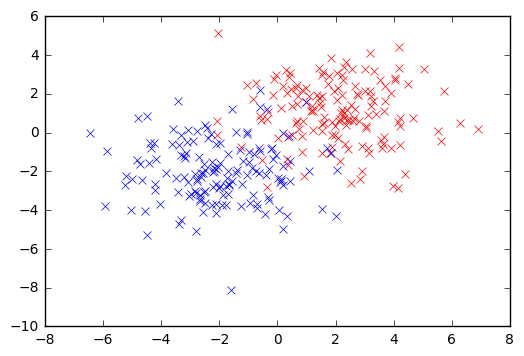

In [4]:
X, y = datasets(name='gaussian', n_points=300)
plot_dataset(X, y)

- The following function qp allows to solve a quadratic problem of the form:

$$
\left\{
  \begin{array}{cll}
  &\min_{(x)} \frac{1}{2}x^{\top} H x - e^\top x
  \\
   & \textrm{s.c.}\; A^\top x = b, 0 \leq x \leq C.
  \end{array}
  \right.
$$

In [5]:
import cvxopt


def qp(H, e, A, b, C=np.inf, l=1e-8, verbose=True):
    # Gram matrix
    n = H.shape[0]
    H = cvxopt.matrix(H)
    A = cvxopt.matrix(A, (1, n))
    e = cvxopt.matrix(-e)
    b = cvxopt.matrix(0.0)
    if C == np.inf:
        G = cvxopt.matrix(np.diag(np.ones(n) * -1))
        h = cvxopt.matrix(np.zeros(n))
    else:
        G = cvxopt.matrix(np.concatenate([np.diag(np.ones(n) * -1),
                                         np.diag(np.ones(n))], axis=0))
        h = cvxopt.matrix(np.concatenate([np.zeros(n), C * np.ones(n)]))

    # Solve QP problem
    cvxopt.solvers.options['show_progress'] = verbose
    solution = cvxopt.solvers.qp(H, e, G, h, A, b)
 
    # Lagrange multipliers
    mu = np.ravel(solution['x'])
    return mu

Definition of the linear kernel:

In [6]:
def kernel(X1, X2):
    n1 = X1.shape[0]
    n2 = X2.shape[0]
    K = np.empty((n1, n2))
    for i in range(n1):
        for j in range(n2):
            K[i, j] = np.dot(X1[i], X2[j])
    return K

### Questions

- Q4: Modify the following cell to solve the SVM dual problem:

Number of support vectors: 3


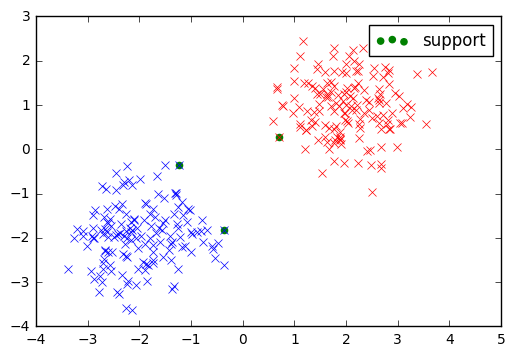

In [7]:
n = 300
X, y = datasets(name='gaussian', n_points=n, sigma=0.7)
plot_dataset(X, y)

def svm_solver(K, y, C=np.inf):
    H = (y * K).T * y
    e = np.ones(y.shape[0])
    A = y
    b = 0
    mu = qp(H, e, A, b, C, l=1e-8, verbose=False)
    idx_support = np.where(np.abs(mu) > 1e-5)[0]
    mu_support = mu[idx_support]
    return mu_support, idx_support

K = kernel(X, X)

# Uncomment the following lines when your svm_solver is completed:
mu_support, idx_support = svm_solver(K, y)
print("Number of support vectors: %s" % idx_support.size)
plt.scatter(X[idx_support][:,0],X[idx_support][:,1],label="support", color='g')
plt.legend()

- Q5: Compute w from mu and b

In [8]:
w = np.sum((mu_support * y[idx_support])[: , None] * X[idx_support], axis=0)
print("weights", w)

weights [ 0.86995836  0.51499716]


- Q6: Using complementary slackness, explain how to obtain $b$ from $\mu$.

HINT: Use the fact that for all support vectors for which $\mu_i$ is non-zero one has $y_{i}(w^{T}x_{i}+b) = 1$.

- A6: 

According to the complementary slackness KKT condition, we have at optimality: 
$ \mu_j(y_{j}(w^{T}x_{j}+b) - 1) = 0 $ for all data points j.

For all support vectors i we have $\mu_i > 0$ and therefore $y_{i}(w^{T}x_{i}+b) - 1 = 0$

Since $y_i\in\{-1,+1\}$:

$$ b = y_i - w^{T}x_{i} $$

and we have that $w = G^{T}\mu = \sum_{j=1}^{n} y_j \mu_j x_j$, therefore: 

$$b = y_i - \sum_{j=1}^{n} y_j \mu_j x_j^T x_i$$ where $i$ is a support vector.

In [9]:
def compute_b(K, y, mu_support, idx_support):
    mu = np.zeros(K.shape[0])
    mu[idx_support] = mu_support
    i = idx_support[0]
    y_i = y[i] 
    #b = y_i - np.sum((y * mu)* K[i, :], axis = 0)
    b = y_i - np.sum((y[idx_support] * mu_support) * K[i, idx_support], axis = 0)
    return b

b = compute_b(K, y, mu_support, idx_support)
print("intercept", b)

intercept 0.253856788289


We compare our weights and intercept with those obtained by SVC in sklearn:

In [10]:
from sklearn.svm import SVC
clf = SVC(kernel='linear', C=np.inf)
clf.fit(X,y)
print("sklearn intercept", clf.intercept_[0])
print("sklearn weights", clf.coef_)
print("same intercept :", np.isclose(clf.intercept_[0], b, rtol=1e-2))
print("same weights", np.isclose(clf.coef_, w, rtol=1e-2).all())

sklearn intercept 0.253637069856
sklearn weights [[ 0.87009112  0.51458288]]
same intercept : True
same weights True


- Q7: Verify that the constraints of the primal problem are satistified up to an acceptable numerical precision. You should verify that for all $i$ we have:

$$
y_{i}(w^{\top}x_{i}+b) \geq 1 - \epsilon
$$

using for example $\epsilon = 1e-5$.

In [11]:
positive = y * (np.dot(X, w) + b*np.ones(n)) - 1 + 1e-5
print("constaints satisfied ", np.all(positive >= 0))

constaints satisfied  True


Check your code by running the following cell:

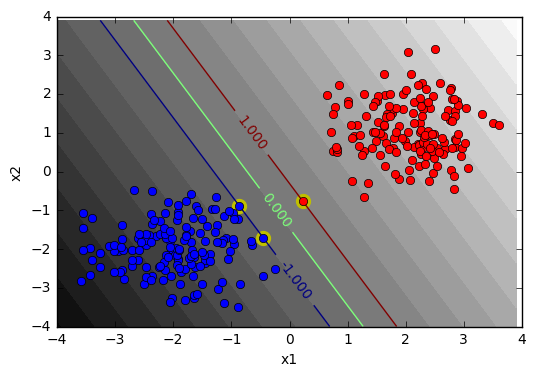

In [12]:
X, y = datasets(name='gaussian', n_points=300, sigma=0.7)

K = kernel(X, X)
mu_support, idx_support = svm_solver(K, y)
b = compute_b(K, y, mu_support, idx_support)

def plot_classif(X, y, mu_support, idx_support, b, kernel=kernel):
    # Calcul de la fonction de décision sur une grille
    X1, X2 = np.mgrid[-4:4:0.1, -4:4:0.1]
    na, nb = X1.shape
    X_test = np.c_[np.reshape(X1, (na * nb, 1)),
                   np.reshape(X2, (na * nb, 1))]

    # Calcul des produits scalaires
    X_support = X[idx_support]
    G = kernel(X_test, X_support)
    # Calcul de la fonction de décision
    decision = G.dot(mu_support * y[idx_support]) + b

    # Calcul du label prédit
    y_pred = np.sign(decision)

    # Affichage des lignes de niveau de la fonction de decision
    plt.contourf(X1, X2, np.reshape(decision, (na, nb)), 20, cmap=plt.cm.gray)
    cs = plt.contour(X1, X2, np.reshape(decision, (na,nb)), [-1, 0, 1], color='g', linewidth=2)
    plt.clabel(cs, inline=1)
    plt.plot(X[y == 1,0], X[y == 1, 1], 'or', linewidth=2)
    plt.plot(X[y == -1,0], X[y == -1, 1], 'ob', linewidth=2)
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.xlim([-4, 4])
    plt.ylim([-4, 4])

plot_classif(X, y, mu_support, idx_support, b)
plt.scatter(X[idx_support][:,0],X[idx_support][:,1],label="support", color = 'y', s=100)

We will now change the value of $\sigma$ such that the problem is not linearily separable anymore.

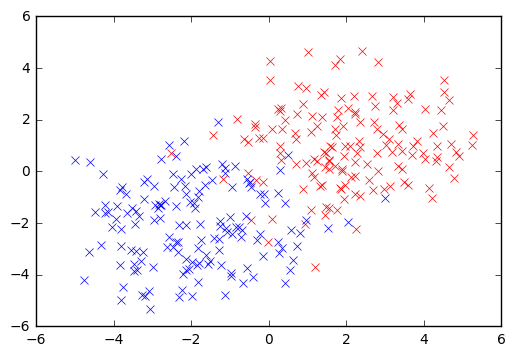

In [13]:
X, y = datasets(name='gaussian', n_points=300, sigma=1.5)
plot_dataset(X, y)

In [14]:
K = kernel(X, X)
mu_support, idx_support = svm_solver(K, y)
b = compute_b(K, y, mu_support, idx_support)
w = np.sum((mu_support * y[idx_support])[: , None] * X[idx_support], axis=0)

Terminated (singular KKT matrix).


- Q8: Check that contraints of the problem are now violated.

In [15]:
positive = y * (np.dot(X, w) + b*np.ones(n)) - 1 + 1e-5
print("constaints satisfied ", np.all(positive >= 0))

constaints satisfied  False


## Part 1: Non separable case with cvxopt

In practice it is very likely that the classes are not linearly separable.

A very natural idea is to relax the constraints $y_{i}(w^\top x_i + b) \geq 1$.
To do this, so called soft-margin SVM have been introduced using
so called slack variables: $\xi_{i}\geq 0$. The problem becomes:

$$
 y_{i}(w^\top x_i + b) \geq 1 - \xi_i, \; \xi_i \geq 0 \enspace .
$$

Note that if $\xi_i > 1$, the sample $x_{i}$ will be misclassified. To prevent
this case to be too frequent, an idea is to minimize the sum of the $\xi_{i}$.
This leads to the following problem:

$$
(P_{s}):  \left\{
 \begin{array}{ll}
 \min_{(w,b,\xi)} & \frac{1}{2}w^{\top}w + C \sum_i \xi_i
 \\
 \mathrm{s.t.} & y_{i}(w^{\top}x_{i}+b) \geq 1 - \xi_i\\
 \mathrm{and} & -\xi_i \leq 0
 \end{array}
 \right.
$$

The constant $C$ controls the regularisation.

### Questions

- Q9: Justify that $(P_{s})$ is a convex problem

- A9: Again, the loss function $J(w,b,\xi) = \frac{1}{2} w^\top w + C \sum_i \xi_i$ is quadratic and semi-definite positive and is thus convex. On the other hand, the constraint functions $1 - \xi_i - y_i(w^\top x_i + b)$ and $-\xi$ are all affine and thus convex too. So, the problem $(P_s)$ is a convex problem.

- Show that a dual problem of $(P_{s})$ reads:

$$
(\mathcal{D}):
\left\{
\begin{array}{lll}
\min_{\mu} &\frac{1}{2}\mu^{\top}GG^{\top}\mu-\mu^{\top}u
\\
\mathrm{s.t.}& y^{\top}\mu = 0
\\
\mathrm{et}& 0 \leq \mu \leq C
\end{array}
\right .
$$

- 
The Lagrangian is given by
$$
L(w,b,\xi,\mu,\nu) = \frac{1}{2} w^\top w + C\sum_i \xi_i + \sum_i \mu_i(1 - \xi_i - y_i (w^\top x_i +b)) + \sum_i \nu_i (-\xi_i)
$$
and the dual problem reads
$$
\begin{cases}
\max_{\mu, \nu} H(\mu,\nu) \\
\mu \geq 0 \\
\nu \geq 0
\end{cases}
$$
where
$$
H(\mu, \nu) = \min_{w,b,\xi} L(w,b,\xi,\mu,\nu)
$$
To get the explicit formula of $H$ we have
$$
\begin{cases}
\frac{\partial}{\partial w} L(w,b,\xi,\mu,\nu) = 0 \\
\frac{\partial}{\partial b} L(w,b,\xi,\mu,\nu) = 0 \\
\frac{\partial}{\partial \xi} L(w,b,\xi,\mu,\nu) = 0
\end{cases}
$$
from which we have
$$
\begin{cases}
w - G^\top \mu = 0 \\
- \mu \cdot y = 0 \\
C\mathbb{1} - \mu - \nu = 0
\end{cases}
$$
Then for $H$ we have
$$
H(\mu) = \frac{1}{2} \mu^\top G G^\top \mu + \mu \cdot (u - G G^\top \mu - y) = -\frac{1}{2} \mu^\top G G^\top \mu + \mu ^\top u
$$
Thus the dual problem can be written as
$$
\begin{cases}
\min_{\mu} \frac{1}{2} \mu^\top G G^\top \mu - \mu ^\top u \\
y^\top \mu = 0\\
\mu \geq 0 \\
\nu \geq 0 \\
\mu + \nu = C \mathbb{1}
\end{cases}
$$
which is equivalent to 
$$
(\mathcal{D}):
\begin{cases}
\min_{\mu} \frac{1}{2} \mu^\top G G^\top \mu - \mu ^\top u \\
y^\top \mu = 0\\
0 \leq \mu \leq C \\
\end{cases}
$$

- Q10: Modify your code from Q4 to handle the non-separable case.

According to the complementary slackness KKT condition for the multiplier $\mu$, we have at optimality: 
$ \mu_j(y_{j}(w^{T}x_{j}+b) - 1 + \xi_j) = 0 $ for all data points j.

For all support vectors i we have $\mu_i > 0$ and therefore $y_{i}(w^{T}x_{i}+b) - 1 + \xi_i = 0$

and therefore we have:

$$ b = y_i - w^{T}x_{i} $$

for $\mu_i > 0$ and $\xi_i = 0$

And therefore we choose a support vector $i$ ($\mu_i > 0$)  for which $\xi_i = 0$

according to the complementary slackness KKT condition for the multiplier $\nu$, we have : $\nu_i \xi_i = 0$. Let's take the case where $\nu_i > 0$ 

From Q9 we have $C\mathbb{1} - \mu - \nu = 0$, which implies that $\mu_i < C$. These are the support vectors that lie on the egde of the margin.

We change slightly the code for computing b to use one of these support vectors. Node that this version also works for SVM without regularization, since $C=+\infty$


In [16]:
def compute_b(K, y, mu_support, idx_support, C):
    mu = np.zeros(K.shape[0])
    mu[idx_support] = mu_support
    # we choose a support vector for which \xi_i = 0, which means \mu_i < C   
    i = idx_support[np.where(C - mu_support > 1e-5)[0][0]]
    y_i = y[i] 
    b = y_i - np.sum((y[idx_support] * mu_support) * K[i, idx_support], axis = 0)
    return b

In [17]:
X, y = datasets(name='gaussian', n_points=300, sigma=1.7)

intercept 0.75533570067
weigths [ 0.87508783  0.77890528]


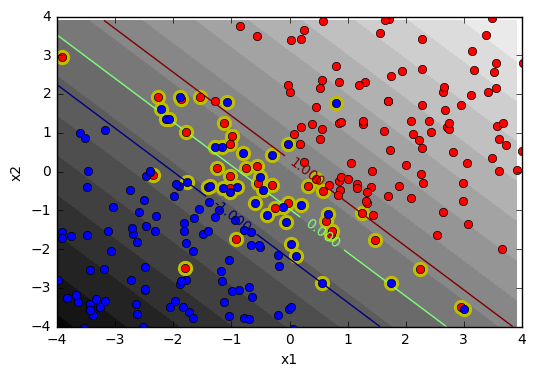

In [18]:
K = kernel(X, X)
C = 1
mu_support, idx_support = svm_solver(K, y, C)
b = compute_b(K, y, mu_support, idx_support, C)
w = np.sum((mu_support * y[idx_support])[: , None] * X[idx_support], axis=0)
plot_classif(X, y, mu_support, idx_support, b)
print("intercept", b)
print("weigths", w)
plt.scatter(X[idx_support][:,0],X[idx_support][:,1],label="support", color = 'y', s=100)

We compare our weights and intercept with those obtained by SVC in sklearn:

In [19]:
from sklearn.svm import SVC
clf = SVC(kernel='linear', C=C)
clf.fit(X,y)
print("sklearn intercept", clf.intercept_[0])
print("sklearn weights", clf.coef_)
print("same intercept :", np.isclose(clf.intercept_[0], b, rtol=1e-2))
print("same weights", np.isclose(clf.coef_, w, rtol=1e-2).all())

sklearn intercept 0.755373829015
sklearn weights [[ 0.87501801  0.77893205]]
same intercept : True
same weights True


- Q11: What is the influence of C on the number of support vectors? Justify this from an optimization stand point.

In [20]:
for C in [0.001, 0.01, 0.1, 1.]:
    mu_support, idx_support = svm_solver(K, y, C)
    print("Number of support vectors: " + str(idx_support.size) +" for C = "  + str(C) ) 

Number of support vectors: 207 for C = 0.001
Number of support vectors: 110 for C = 0.01
Number of support vectors: 70 for C = 0.1
Number of support vectors: 60 for C = 1.0


- A11: A support vector here is  a point that falls, that is either on the edge of the margin, or that violates the margin (either correctly classified or misclassified). The smaller C is, the less we penalize the misclassificaion in the optimization, the more likely the optimization finds a large margin, and more misclassified points, and so the more support vectors we have. In short, C is negatively correlated with the number of support vectors.

## Part 2: non-linear case with kernels

Another scenario is when the boundary between classes is not linear.

To cope with this the idea is to use kernels.

- Q12: Denoting by $K(x_i, x_j)$ the dot product between samples show that dual problem and the decision function f(x) can be reformulated just using calls to $K$

- A12:
With $K(x_i,x_j)$, the dual problem becomes
$$
\begin{cases}
\min_{\mu} \frac{1}{2} \sum_{i,j} \mu_i \mu_j y_i y_j K(x_i,x_j) - \mu ^\top u \\
y^\top \mu = 0\\
0 \leq \mu \leq C \\
\end{cases}
$$
Where $K(x_i,x_j) = \phi(x_i) \cdot \phi(x_j)$

$w$ satisfies:
$$ w = \sum_{i=1}^n \mu_i y_i \phi(x_i)$$
Thus the prediction function becomes:

$$ 
 \begin{array}{l}
 f(x)&= \mathrm{sign}(w^T \phi(x) + b) \\ &= \mathrm{sign}(\sum_{i=1}^{n} \mu_i y_i \phi(x_i)^\top \phi(x) + b) \\
 &= \mathrm{sign}(\sum_{i=1}^{n} \mu_i y_i K(x_i,x) + b)
  \end{array}
 $$

We will use the clowns dataset to evaluate this:

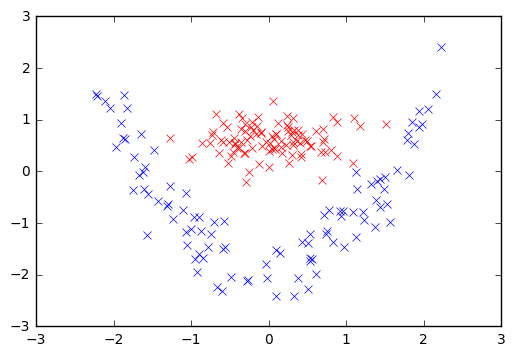

In [21]:
X, y = datasets(name='clowns', n_points=200, sigma=0.7)
plot_dataset(X, y)

- Q13: Update your kernel function so it computes the Gaussian kernel:

$$
    K(x_i, x_j) = \exp(-\gamma \| x_i - x_j \|)
$$

where $\gamma > 0$ is the kernel bandwidth.

In [22]:
from scipy import linalg

def rbf_kernel(X1, X2):
    n1 = X1.shape[0]
    n2 = X2.shape[0]
    K = np.empty((n1, n2))
    gamma = 3.
    for i in range(n1):
        for j in range(n2):
            K[i, j] = np.exp(-gamma * np.linalg.norm(X1[i] - X2[j]))
    return K

Using the change above the follwing code should allow you to nicely separate the red from the blue dots

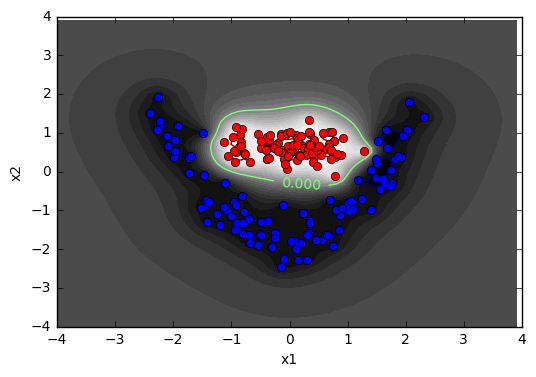

In [23]:
X, y = datasets(name='clowns', n_points=200, sigma=0.7)
K = rbf_kernel(X, X)
C = np.inf
mu_support, idx_support = svm_solver(K, y, C=C)
b = compute_b(K, y, mu_support, idx_support, C=C)
plot_classif(X, y, mu_support, idx_support, b, kernel=rbf_kernel)

## Part 3: Linear SVM without intercept

The problem of the formuation of SVMs with the intercept term $b$ is that
it leads to an annoying constraint in the dual, namely the $y^{T}\mu = 0$.

We will now see what we can do about it.

Let's consider the problem

$$
(P'_{s}):  \left\{
 \begin{array}{ll}
 \min_{(w,\xi)} & \frac{1}{2}w^{\top}w + C \sum_i \xi_i
 \\
 \mathrm{s.t.} & y_{i}(w^{\top}x_{i}) \geq 1 - \xi_i\\
 \mathrm{and} & -\xi_i \leq 0
 \end{array}
 \right.
$$

- Q14: Show that a dual problem of $(P'_{s})$ is given by:

$$
(\mathcal{D}):
\left\{
\begin{array}{lll}
\min_{\mu} &\frac{1}{2}\mu^{\top}GG^{\top}\mu-\mu^{\top} 1_n
\\
\mathrm{s.t.}& 0 \leq \mu \leq C
\end{array}
\right .
$$

- A14:
The Lagrangian is given by
$$
L(w,\xi,\mu,\nu) = \frac{1}{2} w^\top w + C\sum_i \xi_i + \sum_i \mu_i(1 - \xi_i - y_i w^\top x_i) + \sum_i \nu_i (-\xi_i)
$$
and the dual problem reads
$$
\begin{cases}
\max_{\mu, \nu} H(\mu,\nu) \\
\mu \geq 0 \\
\nu \geq 0
\end{cases}
$$
where
$$
H(\mu, \nu) = \min_{w,\xi} L(w,\xi,\mu,\nu)
$$
To get the explicit formula of $H$ we have
$$
\begin{cases}
\frac{\partial}{\partial w} L(w,\xi,\mu,\nu) = 0 \\
\frac{\partial}{\partial \xi} L(w,\xi,\mu,\nu) = 0
\end{cases}
$$
from which we have
$$
\begin{cases}
w - G^\top \mu = 0 \\
C\mathbb{1} - \mu - \nu = 0
\end{cases}
$$
Then for $H$ we have
$$
H(\mu) = \frac{1}{2} \mu^\top G G^\top \mu + \mu \cdot (u - G G^\top \mu - y) = -\frac{1}{2} \mu^\top G G^\top \mu + \mu ^\top u
$$
Thus the dual problem can be written as
$$
\begin{cases}
\min_{\mu} \frac{1}{2} \mu^\top G G^\top \mu - \mu ^\top u \\
\mu \geq 0 \\
\nu \geq 0 \\
\mu + \nu = C \mathbb{1}
\end{cases}
$$
which is equivalent to 
$$
(\mathcal{D}):
\begin{cases}
\min_{\mu} \frac{1}{2} \mu^\top G G^\top \mu - \mu ^\top 1_n \\
0 \leq \mu \leq C \\
\end{cases}
$$

- Q15: Rewrite the dual in the form:


$$
(\mathcal{D}): \min_{\mu} f(\mu) + g(\mu) .
$$

where $f$ is here a smooth function of $\mu$ with L-Liptschitz gradient and $g$ is a non-smooth function that is separable, namely:

$$
g(\mu) = \sum_{i=1}^n g_i(\mu_i)
$$

- A15:
We write 
$$f(\mu) = \frac{1}{2} \mu^\top G G^\top \mu - \mu ^\top 1_n $$
and 
$$
g(\mu) = \sum_{i=1}^n g_i (\mu_i)
$$
where
$$
g_i(\mu_i) = \mathbb{I}_{[0,C]}(\mu_i) = 
\begin{cases}
0, \quad \text{if } \mu_i \in [0,C] \\
+\infty, \quad \text{if } \mu_i \not \in [0,C]
\end{cases}
$$
Then the problem $(\mathcal{D})$ can be written in the form:
$$
(\mathcal{D}): \min_{\mu} f(\mu) + g(\mu).
$$
$f$ is a quadratic form and :
$$
\nabla f (\mu) = GG^T \mu - 1_n
$$
$$
\nabla^2 f(\mu) = GG^T
$$
We see that $f$ is $L$-smooth where
$$
L = \| G G^\top \|_{op}
$$

The dual in the later form can be readily optimized using the methods that you have been studying in this class:

- Proximal gradient method with and without acceleration
- L-BFGS-B
- Coordinate descent

- Q16: Implement:

   - your own version of proximal gradient with and without acceleration
   - your own version of coordinate descent
   - an L-BFGS-B solver using `scipy.optimize.fmin_l_bfgs_b`

Note: We restrict ourselves to linear kernel here.

Note: To handle separating hyperplanes which do not pass throw zero (due to absence of intercept)
you will add a column of ones to X. You can use something like this:

`X = np.concatenate((X, np.ones((len(X), 1))), axis=1)`

You will test your implementations on the Gaussian blobs and evaluate the performance of your implementations in terms of computation time on problems where the matrix $G G^\top$ can fit in memory.

You should reuse as much as possible the convergence evaluation code that you used during the labs.

For a coordinate descent method to be fast you need to have smart updates. You're expected to
come up with these smart updates in the problem at hand.

BONUS : With a smart implementation of the coordinate descent you should be able to scale the optimization to tens of thousands of samples ie cases where $G G^\top$ does not fit in memory anymore.

**IMPORTANT : This question Q16 is the most important and will constitute half of the final grade on the project !**

### A16

The following function allows to solve a quadratic problem of the form:

$$
\left\{
  \begin{array}{cll}
  &\min_{(x)} \frac{1}{2}x^{\top} H x - e^\top x
  \\
   & \textrm{u.c.}\; 0 \leq x \leq C.
  \end{array}
  \right.
$$

In [24]:
def qp_no_intercept(H, e, C=np.inf, l=1e-8, verbose=True):
    # Gram matrix
    n = H.shape[0]
    H = cvxopt.matrix(H)
    e = cvxopt.matrix(-e)
    if C == np.inf:
        G = cvxopt.matrix(np.diag(np.ones(n) * -1))
        h = cvxopt.matrix(np.zeros(n))
    else:
        G = cvxopt.matrix(np.concatenate([np.diag(np.ones(n) * -1),
                                         np.diag(np.ones(n))], axis=0))
        h = cvxopt.matrix(np.concatenate([np.zeros(n), C * np.ones(n)]))

    # Solve QP problem
    cvxopt.solvers.options['show_progress'] = verbose
    solution = cvxopt.solvers.qp(H, e, G, h)
 
    # Lagrange multipliers
    mu = np.ravel(solution['x'])
    return mu

#### SVM class

In [71]:
from scipy.linalg import svd
from scipy.linalg import norm

class Svm(object):
    """
        A class for a minimization problem in the form f(x) = 1/2 <x, Hx> - <x, e> + g(x) where H = GGT and e = 1n.
        x in the code represents \mu
    """

    def __init__(self, X, y, c):
        self.X = X
        self.y = y
        self.c = c
        K = kernel(X, X)
        self.H = (y * K).T * y
        self.n = y.shape[0]
        self.e = np.ones(self.n)  
    
    def g(self, x):
        """ Indicator function of [0, C] """
        if np.any(x < 0):
            return np.inf
        if not np.isinf(self.c):
            if np.any(x > self.c):
                return np.inf
        return 0

    def prox_g(self, x):
        """ Projection on [0, C] : max(0, min(x, C)) """
        if(x.shape):
            res = x.copy()
            if not np.isinf(self.c):
                res[x > self.c] = self.c
                res[x < 0] = 0
            else: 
                res[x < 0] = 0
            return res
        else:
            if not np.isinf(self.c):
                res = max(0, min(x, self.c))
            else:
                res = max(0, x)
            return res
        
    def loss(self, x):
        """Dual SVM loss"""
        return 1. / 2 * x.dot(self.H.dot(x)) - x.dot(self.e) + self.g(x)
    
    def loss_smooth(self, x):
        """ Smooth part of the loss"""
        return 1. / 2 * x.dot(self.H.dot(x)) - x.dot(self.e)
    
    def grad(self, x):
        """ Gradient of the smooth part of the loss """
        return self.H.dot(x) - self.e
    
    def grad_i(self, x, i):
        """ Returns the ith component of the gradient ∇f """
        return np.dot((self.H)[:, i], x) - (self.e)[i]
    
    def grad_i_2(self, w, i):
        """ Computes the ith component of the gradient ∇f using w """
        return self.y[i] * np.dot(w, X[i, :]) - 1
    
    def get_w(self, x):
        return np.sum( (self.y * x)[:, None] * self.X, axis=0)
    
    def update_w(self, x_i_old, x_i, old_w, i):
        return old_w + (x_i - x_i_old) * self.y[i] * self.X[i, :]
    
    def lipschitz_i(self):
        return np.diagonal(self.H)

    def lipschitz_constant(self):
        """Returns the Lipschitz constant of the gradient""" 
        return norm(self.H, ord=2)
        
    

#### Utils

In [26]:
def get_support_vec(mu):
    idx_support = np.where(np.abs(mu) > 1e-5)[0]
    mu_support = mu[idx_support]
    return mu_support, idx_support

Since we have appended a column of ones to X, i.e: $x_i^T \leftarrow [x_i^T, 1]$ 

Then $w^T \leftarrow [w^T, b]$

In [27]:
def compute_w_b(mu, y, X):
    mu_support, idx_support = get_support_vec(mu)
    w = np.sum((mu_support * y[idx_support])[: , None] * X[idx_support], axis=0)
    return w[:-1], w[2]

#### Dataset and model 

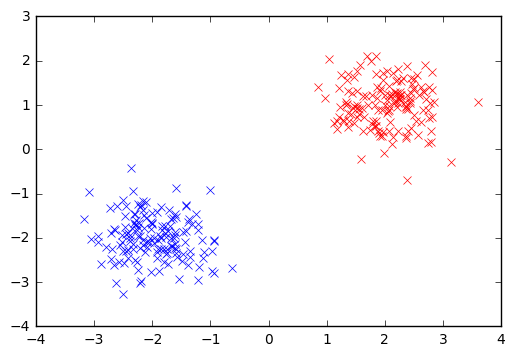

In [28]:
X, y = datasets(name='gaussian', n_points=300, sigma=0.5)
plot_dataset(X, y)
X = np.concatenate((X, np.ones((len(X), 1))), axis=1)

In [29]:
c = np.inf # this can be changed to other values
model = Svm(X, y, c)

#### Find true minimum and minimizer using qp solver
Sometimes the objective that we get using qp solver is eqaul to np.inf, meaning x_min has some negative components

In [30]:
# Find the true x_min and f_min
x_min = np.zeros(model.n)
x_min = qp_no_intercept(model.H, model.e, c, l=1e-8, verbose=False)
f_min = model.loss(x_min)
print(f_min)

-0.299760457664


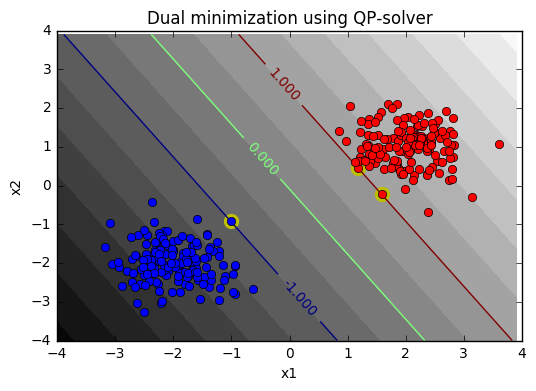

In [31]:
mu_support, idx_support = get_support_vec(x_min)
_, b = compute_w_b(x_min, y, X)
plot_classif(X[:, :-1], y, mu_support, idx_support, b)
plt.scatter(X[idx_support][:,0],X[idx_support][:,1],label="support", color = 'y', s=100)
plt.title("Dual minimization using QP-solver")

In [32]:
def inspector(loss_fun, verbose=False):
    """A closure called to update metrics after each iteration."""
    objectives = []
    errors = []
    it = [0] # This is a hack to be able to modify 'it' inside the closure.
    def inspector_cl(xk):
        obj = loss_fun(xk) - f_min
        err = norm(xk - x_min)
        objectives.append(obj)
        errors.append(err)
        if verbose == True:
            if it[0] == 0:
                print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
            if it[0] % (n_iter / 5) == 0:
                print(' | '.join([("%d" % it[0]).rjust(8), ("%.2e" % obj).rjust(8), ("%.2e" % err).rjust(8)]))
            it[0] += 1
    inspector_cl.obj = objectives
    inspector_cl.err = errors
    return inspector_cl

### Proximal Gradient with and without accelaration

### ISTA

We recall that an iteration of ISTA (actually a batch gradient here) writes

$$
x_{k+1} \gets x_k - \eta \nabla f(x_k)
$$

where $\eta$ is the step-size (that can be chosen in theory as $\eta = 1 / L$, with $L$ the Lipshitz constant of $\nabla f$, see above)

In [33]:
def ista(x_init, grad, prox, n_iter=100, step=1., callback=None):
    """ISTA algorithm."""
    x = x_init.copy()
    
    for _ in range(n_iter):
        x = prox(x - step * grad(x))   
        # Update metrics after each iteration.
        if callback: 
            callback(x)
    return x

In [34]:
%%time
n_iter = 50000
step = 1. / model.lipschitz_constant()
x_init = np.zeros(model.n)
ista_inspector = inspector(model.loss, verbose=True)
x_ista = ista(x_init, model.grad, model.prox_g, n_iter, step, callback=ista_inspector)

   it    |   obj    |   err   
       0 | 2.20e-01 | 4.16e-01
   10000 | 2.36e-03 | 1.46e-01
   20000 | 5.04e-04 | 5.66e-02
   30000 | 3.02e-05 | 1.53e-02
   40000 | 2.20e-06 | 4.15e-03
CPU times: user 12.2 s, sys: 425 ms, total: 12.6 s
Wall time: 9.48 s


In [35]:
print(get_support_vec(x_ista))
print(get_support_vec(x_min))

(array([ 0.01208938,  0.30617132,  0.28120052]), array([  4,  10, 156]))
(array([ 0.01137661,  0.30703886,  0.28110543]), array([  4,  10, 156]))


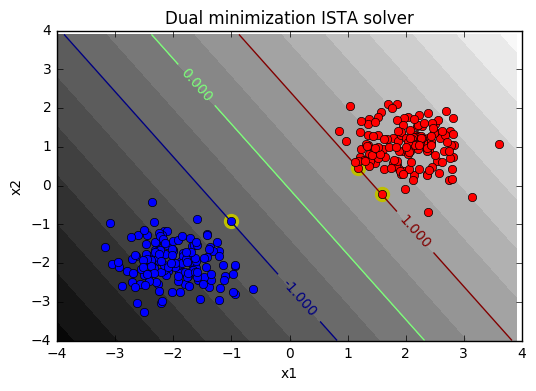

In [36]:
mu_support, idx_support = get_support_vec(x_ista)
_, b = compute_w_b(x_ista, y, X)
plot_classif(X[:, :-1], y, mu_support, idx_support, b)
plt.scatter(X[idx_support][:,0],X[idx_support][:,1],label="support", color = 'y', s=100)
plt.title("Dual minimization ISTA solver")

### FISTA

We recall that an iteration of FISTA (actually an accelerated batch gradient here) writes

$$
\begin{align*}
x_{k+1} &\gets y_k - \eta \nabla f(y_k) \\
t_{k+1} &\gets \frac{1 + \sqrt{1 + 4 t_k^2}}{2} \\
y_{k+1} &\gets x_{k+1} + \frac{t_k-1}{t_{k+1}} (x_{k+1} - x_k)
\end{align*}
$$

where $\eta$ is the step-size (that can be chosen in theory as $\eta = 1 / L$, with $L$ the Lipshitz constant of $\nabla f$, see above)

In [37]:
def fista(x_init, grad, prox, n_iter=100, step=1., callback=None):
    """FISTA algorithm."""
    x = x_init.copy()
    y = x_init.copy() 
    t = 1.

    for _ in range(n_iter):
        x_new = prox(y - step * grad(x))
        t_new = (1. + np.sqrt(1 + 4 * t * t)) / 2
        y = x_new + (t - 1) / t_new * (x_new - x)
        x = x_new
        t = t_new
    
        # Update metrics after each iteration.
        if callback: 
            callback(x)
    return x

In [38]:
%%time
n_iter = 50000
step = 1. / model.lipschitz_constant()
x_init = np.zeros(model.n)
fista_inspector = inspector(model.loss, verbose=True)
x_fista = fista(x_init, model.grad, model.prox_g, n_iter, step, callback=fista_inspector)

   it    |   obj    |   err   
       0 | 2.20e-01 | 4.16e-01
   10000 | -2.17e-08 | 1.35e-04
   20000 | -2.33e-08 | 6.32e-05
   30000 | -2.42e-08 | 5.34e-05
   40000 | -2.48e-08 | 1.02e-05
CPU times: user 13.4 s, sys: 504 ms, total: 13.9 s
Wall time: 11.2 s


In [39]:
print(get_support_vec(x_fista))
print(get_support_vec(x_min))

(array([ 0.01136507,  0.30705434,  0.28111297]), array([  4,  10, 156]))
(array([ 0.01137661,  0.30703886,  0.28110543]), array([  4,  10, 156]))


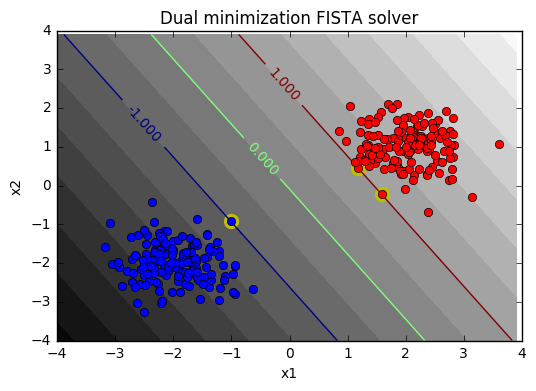

In [40]:
mu_support, idx_support = get_support_vec(x_fista)
_, b = compute_w_b(x_fista, y, X)
plot_classif(X[:, :-1], y, mu_support, idx_support, b)
plt.scatter(X[idx_support][:,0],X[idx_support][:,1],label="support", color = 'y', s=100)
plt.title("Dual minimization FISTA solver")

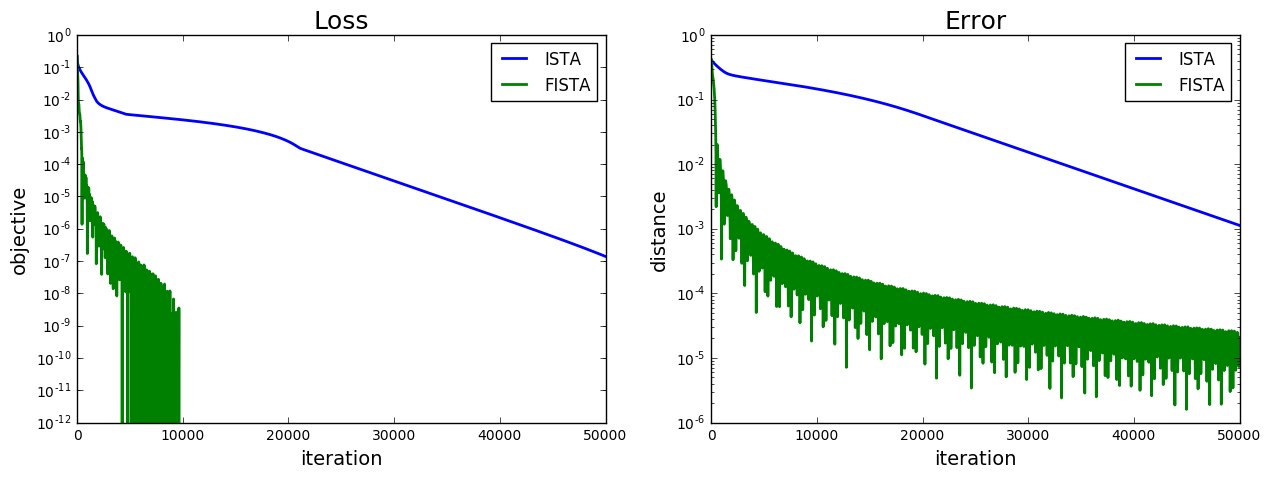

In [41]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)

inspectors = [ista_inspector, fista_inspector]

solvers = ["ISTA", "FISTA"]

for insp in inspectors:
    plt.plot(insp.obj, lw=2)
    plt.title("Loss", fontsize=18)
    plt.xlabel("iteration", fontsize=14)
    plt.ylabel("objective", fontsize=14)
    plt.yscale("log")

plt.legend(solvers)

plt.subplot(1, 2, 2)

for insp in inspectors:
    plt.plot(insp.err, lw=2)
    plt.title("Error", fontsize=18)
    plt.xlabel("iteration", fontsize=14)
    plt.ylabel("distance", fontsize=14)
    plt.yscale("log")

plt.legend(solvers);


### L-BFGS-B solver

In [42]:
%%time
from scipy.optimize import fmin_l_bfgs_b
n_iter = 1000
x_init = np.zeros(model.n)
bounds = [(0, c) for i in range(model.n)]
scipy_l_bfgs_b_inspector = inspector(model.loss, verbose=True)
x_lbfgs, f_lbfgs, _ = fmin_l_bfgs_b(model.loss_smooth, x_init, fprime=model.grad, factr=10., bounds=bounds, maxiter=n_iter, callback=scipy_l_bfgs_b_inspector)

   it    |   obj    |   err   
       0 | 2.20e-01 | 4.16e-01
CPU times: user 37.8 ms, sys: 4.09 ms, total: 41.9 ms
Wall time: 41.9 ms


In [43]:
print(get_support_vec(x_min))
print(get_support_vec(x_lbfgs))

(array([ 0.01137661,  0.30703886,  0.28110543]), array([  4,  10, 156]))
(array([ 0.01138537,  0.307027  ,  0.28110773]), array([  4,  10, 156]))


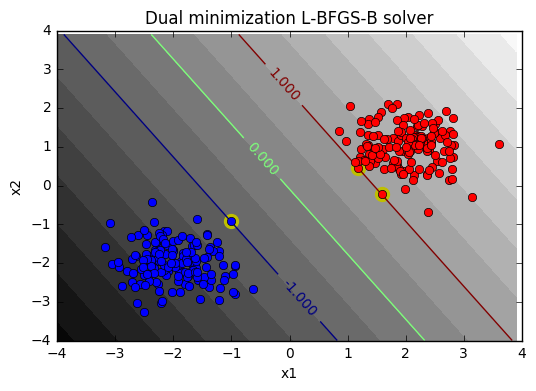

In [44]:
mu_support, idx_support = get_support_vec(x_lbfgs)
_, b = compute_w_b(x_lbfgs, y, X)
plot_classif(X[:, :-1], y, mu_support, idx_support, b)
plt.scatter(X[idx_support][:,0],X[idx_support][:,1],label="support", color = 'y', s=100)
plt.title("Dual minimization L-BFGS-B solver")

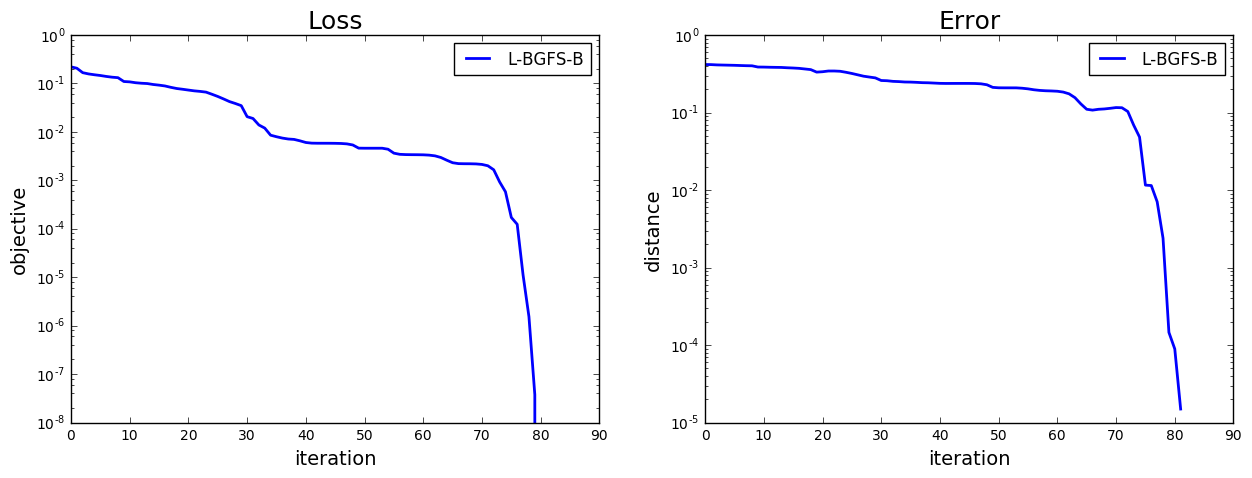

In [45]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)

inspectors = [scipy_l_bfgs_b_inspector]

solvers = ["L-BGFS-B"]

for insp in inspectors:
    plt.plot(insp.obj, lw=2)
    plt.title("Loss", fontsize=18)
    plt.xlabel("iteration", fontsize=14)
    plt.ylabel("objective", fontsize=14)
    plt.yscale("log")

plt.legend(solvers)

plt.subplot(1, 2, 2)

for insp in inspectors:
    plt.plot(insp.err, lw=2)
    plt.title("Error", fontsize=18)
    plt.xlabel("iteration", fontsize=14)
    plt.ylabel("distance", fontsize=14)
    plt.yscale("log")

plt.legend(solvers);

### Coordinate Descent (without smart updates)

In [46]:
def cd(x_init, n, grad, prox, n_iter=100, step=1., callback=None):
    x = x_init.copy()
    
    for k in range(n_iter):
        i = k % n
        x[i] = prox(x[i] - step[i] * grad(x, i))
         # Update metrics after each iteration.
        if callback: 
            callback(x)
    return x

In [47]:
%%time
n_iter = 50000
x_init = np.zeros(model.n)
cd_inspector = inspector(model.loss, verbose=True)
x_cd = cd(x_init, model.n, model.grad_i, model.prox_g, n_iter, 1. / model.lipschitz_i(), callback=cd_inspector)

   it    |   obj    |   err   
       0 | 1.95e-01 | 4.66e-01
   10000 | 9.47e-08 | 9.34e-04
   20000 | -2.49e-08 | 2.31e-06
   30000 | -2.49e-08 | 7.99e-08
   40000 | -2.49e-08 | 8.54e-08
CPU times: user 7.44 s, sys: 228 ms, total: 7.67 s
Wall time: 4.82 s


In [48]:
print(get_support_vec(x_cd))
print(get_support_vec(x_min))

(array([ 0.01137657,  0.30703894,  0.28110545]), array([  4,  10, 156]))
(array([ 0.01137661,  0.30703886,  0.28110543]), array([  4,  10, 156]))


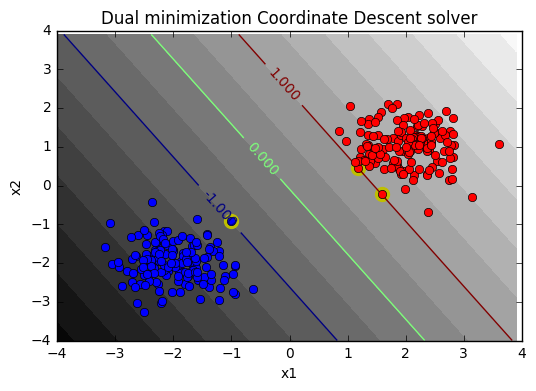

In [49]:
mu_support, idx_support = get_support_vec(x_cd)
_, b = compute_w_b(x_cd, y, X)
plot_classif(X[:, :-1], y, mu_support, idx_support, b)
plt.scatter(X[idx_support][:,0],X[idx_support][:,1],label="support", color = 'y', s=100)
plt.title("Dual minimization Coordinate Descent solver")

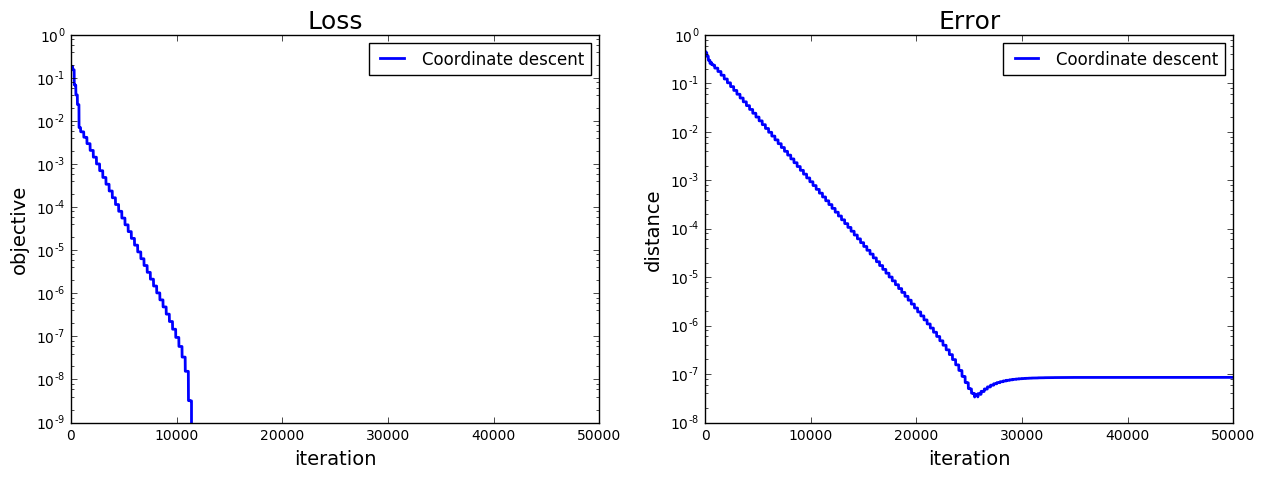

In [50]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)

inspectors = [cd_inspector]

solvers = ["Coordinate descent"]

for insp in inspectors:
    plt.plot(insp.obj, lw=2)
    plt.title("Loss", fontsize=18)
    plt.xlabel("iteration", fontsize=14)
    plt.ylabel("objective", fontsize=14)
    plt.yscale("log")

plt.legend(solvers)

plt.subplot(1, 2, 2)

for insp in inspectors:
    plt.plot(insp.err, lw=2)
    plt.title("Error", fontsize=18)
    plt.xlabel("iteration", fontsize=14)
    plt.ylabel("distance", fontsize=14)
    plt.yscale("log")

plt.legend(solvers);

### Coordinate Descent (with smart updates)

The classical coordinate descent algorithm computes $\nabla_i f(\mu)$ by:
$$
\nabla_i f(\mu) = GG^T_{:, i} \cdot \mu - 1
$$
which is dot product of two vectors of size $n$, i.e. in $O(n)$.

For linear SVM we have: 
$$ 
w = \sum_{i=1}^n \mu_i y_i x_i
$$

So $\nabla_i f(\mu)$ becomes:
$$
\nabla_i f(\mu) =  \sum_{i=1}^n y_i w^T x_i -1
$$

The main cost to evaluate this gradient is in $O(d)$ (number of features of an observation $x_i$), which is much smaller than $O(n)$ for the problems we are considering.

To apply this gradient, we need to update $w$. Since using the previous identity for $w$ is too expensive (in $O(nd)$), we use the residual in $\mu^{(i)}$, namely:
$$
w_{k+1} = w_{k} + (\mu_{k+1} ^{(i)} - \mu_{k} ^{(i)}) y_i x_i
$$
which is only in $O(d)$.

In [51]:
def cd_smart(x_init, n, grad, get_w, update_w, prox, n_iter=100, step=1., callback=None):
    x = x_init.copy()
    w = get_w(x)
    for k in range(n_iter):
        i = k % n
        xi_old = x[i]
        x[i] = prox(x[i] - step[i] * grad(w, i))
        w = update_w(xi_old, x[i], w, i)
        
        if callback: 
            callback(x)
    return x

In [52]:
%%time
n_iter = 50000
x_init = np.zeros(model.n)
cd_smart_inspector = inspector(model.loss, verbose=True)
x_cd_smart = cd_smart(x_init, model.n, model.grad_i_2, model.get_w, model.update_w, 
                      model.prox_g, n_iter,  1. / model.lipschitz_i(), callback=cd_smart_inspector)

   it    |   obj    |   err   
       0 | 1.95e-01 | 4.66e-01
   10000 | 9.47e-08 | 9.34e-04
   20000 | -2.49e-08 | 2.31e-06
   30000 | -2.49e-08 | 7.99e-08
   40000 | -2.49e-08 | 8.54e-08
CPU times: user 7.86 s, sys: 226 ms, total: 8.08 s
Wall time: 5.49 s


In [53]:
print(get_support_vec(x_cd_smart))
print(get_support_vec(x_min))

(array([ 0.01137657,  0.30703894,  0.28110545]), array([  4,  10, 156]))
(array([ 0.01137661,  0.30703886,  0.28110543]), array([  4,  10, 156]))


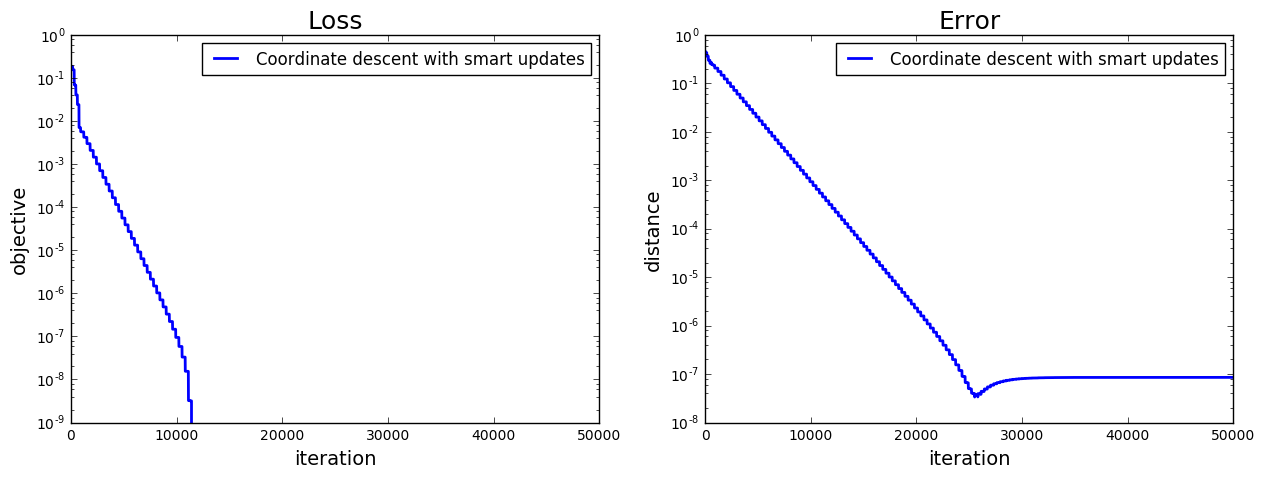

In [54]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)

inspectors = [cd_smart_inspector]

solvers = ["Coordinate descent with smart updates"]

for insp in inspectors:
    plt.plot(insp.obj, lw=2)
    plt.title("Loss", fontsize=18)
    plt.xlabel("iteration", fontsize=14)
    plt.ylabel("objective", fontsize=14)
    plt.yscale("log")

plt.legend(solvers)

plt.subplot(1, 2, 2)

for insp in inspectors:
    plt.plot(insp.err, lw=2)
    plt.title("Error", fontsize=18)
    plt.xlabel("iteration", fontsize=14)
    plt.ylabel("distance", fontsize=14)
    plt.yscale("log")

plt.legend(solvers);

### Coordinate Descent (with smart updates): second version

Here we maintain the whole gradient, so that $\nabla_i f(\mu)$ is directly available. The update from $\mu_k$ to $\mu_{k+1}$ ($x$ in our code) is in $O(1)$, and updating the whole gradient is done by: 
$$
\nabla f(\mu_{k+1}) = \nabla f(\mu_{k}) + GG^T_{:, i}(\mu_{k+1}^{(i)} - \mu_{k}^{(i)})
$$
where $ GG^T_{:, i}$ is *ith* column of $GG^T$. The cost of this update is in $O(n)$

On the other hand, the classical coordinate descent algorithm computes $\nabla_i f(\mu)$ by:
$$
\nabla_i f(\mu_) = GG^T_{:, i} \cdot \mu - 1
$$
Which is also in $O(n) $, so it doesn't cost more to maintain the whole gradient.

The improvement is to only update the whole gradient only if necessary. After a sufficient number of iterations, some $\mu_i$ converge, and we no longer need to update the gradient in the directions $i$. This saves a lot of computation effort.

In [55]:
def cd_smart_2(x_init, n, grad, H, prox, n_iter=100, step=1., callback=None):
    x = x_init.copy()
    grad_global = grad(x)
    for k in range(n_iter):
        i = k % n
        xi_old = x[i]
        x[i] = prox(x[i] - step[i] * grad_global[i])
        dxi = x[i] - xi_old
        if abs(dxi) > 1e-8:
            grad_global += H[:, i] * dxi
        
        if callback: 
            callback(x)
    return x

In [56]:
%%time
n_iter = 50000
x_init = np.zeros(model.n)
cd_smart2_inspector = inspector(model.loss, verbose=True)
x_cd_smart2 = cd_smart_2(x_init, model.n, model.grad, model.H, model.prox_g, n_iter, 
                         1./ model.lipschitz_i(), callback=cd_smart2_inspector)

   it    |   obj    |   err   
       0 | 1.95e-01 | 4.66e-01
   10000 | 9.47e-08 | 9.34e-04
   20000 | -2.49e-08 | 2.31e-06
   30000 | -2.49e-08 | 1.89e-07
   40000 | -2.49e-08 | 6.06e-07
CPU times: user 6.92 s, sys: 184 ms, total: 7.11 s
Wall time: 4.49 s


In [57]:
print(get_support_vec(x_cd_smart2))
print(get_support_vec(x_min))

(array([ 0.01137596,  0.30703888,  0.28110464]), array([  4,  10, 156]))
(array([ 0.01137661,  0.30703886,  0.28110543]), array([  4,  10, 156]))


### Comparison of the different implementations of Coordinate Descent on a medium scale dataset

In [58]:
from timeit import timeit

X, y = datasets(name='gaussian', n_points=7000, sigma=0.7)
X = np.concatenate((X, np.ones((len(X), 1))), axis=1)
c = np.inf # this can be changed to other values
model = Svm(X, y, c)

x_init = np.zeros(model.n)
n_iter = 50000

print("CD")
r1 = timeit(stmt=lambda: cd(x_init, model.n, model.grad_i, model.prox_g, n_iter, 1. / model.lipschitz_i()), number=5)
print("\t", r1, "seconds")

print("CD with smart updates")
r2 = timeit(stmt=lambda: cd_smart(x_init, model.n, model.grad_i_2, model.get_w, model.update_w,
                                  model.prox_g, n_iter, 1. / model.lipschitz_i()), number=5)
print("\t", r2, "seconds")

print("CD with smart updates, second version")
r3 = timeit(stmt=lambda: cd_smart_2(x_init, model.n, model.grad, model.H, model.prox_g, n_iter, 
                                    1. / model.lipschitz_i()), number=5)
print("\t", r3, "seconds")



CD
	 3.51927471099998 seconds
CD with smart updates
	 2.3513604670000063 seconds
CD with smart updates, second version
	 1.0273758689999966 seconds


### Comparison and conclusion
Here we consider that

Our two proximal gradient algorithms had their performance as expected. ISTA converges at rate $O(1/k)$ and is a descent algorithm. FISTA improve the rate to $O(1/k^2)$ but is not a descent algorithm anymore. 
The cost of both ISTA and FISTA is $O(nd)$ per iteration.

L-BFGS-B converges very quickly compared to all algorithms, and requires the smallest computation time.

We implemented several versions of the coordinate descent algorithms.

The simple version without smart updates converges quickly even compared to ISTA, meaning that we need less evaluations of the full gradient than for ISTA to reach convergence. It is due to the fact that $L_i \lt L(\nabla f)$. However, in terms of computational cost per iteration, The simple version of coordinate descent has a cost of $O(n)$ per iteration, which means $O(n^2)$ in order to cycle through all the componenents of the gradient.

The first version with smart updates reduces $O(n)$ to $O(d)$ for one coordinate descent iteration (which means we go from $O(n^2)$ to $O(nd)$ for updating all the compoments), and thus is less computationnally expensive than the previous one.

The second version with smart updates has the same theroretical complexity as the simple coordinate descent algorithm ($O(n)$ per iteration), but eliminates unnecessary updates which saves a lot of computation time.

These results are confirmed by the execution times that we have computed for the three versions of coordinate descent, for a medium scale dataset.


### Bonus Question

We rewrite the SVM class to adapt it to a setting where n > 10000 samples, and we can't store GG^T in memory.

For the optimisation, We use the first version of coordinate descent with smart updates, in which every iteration costs $O(d)$, and the cost of updating all the components of mu is $O(nd)$. The main memory requirement is storing $x_1 ,\dots , x_n$ .

In [59]:
class Svm_online(object):
    """
        A class for a minimization problem in the form f(x) = 1/2 <x, Hx> - <x, e> + g(x) where H = GGT and e = 1n, 
        without storing H = GG^T
    """

    def __init__(self, X, y, c):
        self.X = X
        self.y = y
        self.c = c
        self.n = y.shape[0]
        self.e = np.ones(self.n)  
    
    def g(self, x):
        """ Indicator function of [0, C] """
        if np.any(x < 0):
            return np.inf
        if not np.isinf(self.c):
            if np.any(x > self.c):
                return np.inf
        return 0

    def prox_g(self, x):
        """ Projection on [0, C] : max(0, min(x, C)) """
        if(x.shape):
            res = x.copy()
            if not np.isinf(self.c):
                res[x > self.c] = self.c
                res[x < 0] = 0
            else: 
                res[x < 0] = 0
            return res
        else:
            if not np.isinf(self.c):
                res = max(0, min(x, self.c))
            else:
                res = max(0, x)
            return res
    
    def grad_i(self, w, i):
        """ Computes the ith component of the gradient ∇f using w """
        return self.y[i] * np.dot(w, X[i, :]) - 1
    
    def get_w(self, x):
        return np.sum( (self.y * x)[:, None] * self.X, axis=0)
    
    def update_w(self, x_i_old, x_i, old_w, i):
        return old_w + (x_i - x_i_old) * self.y[i] * self.X[i, :]
    
    def lipschitz_i(self, i):
        return np.dot(self.X[i, :], self.X[i, :].T)

    

#### Dataset with tens of thousands of samples 

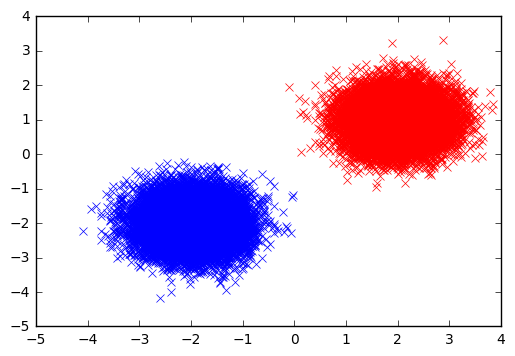

In [60]:
X, y = datasets(name='gaussian', n_points=30000, sigma=0.5)
plot_dataset(X, y)
X = np.concatenate((X, np.ones((len(X), 1))), axis=1)

In [61]:
c = np.inf # value can be changed 
model_online = Svm_online(X, y, c)

In [66]:
def cd_online(x_init, n, grad, get_w, update_w, prox, n_iter=100, step=1.):
    x = x_init.copy()
    w = get_w(x)
    for k in range(n_iter):
        i = k % n
        xi_old = x[i]
        x[i] = prox(x[i] - 1. / step(i) * grad(w, i))
        w = update_w(xi_old, x[i], w, i)
    return x

In [67]:
%%time
n_iter = 1500000
x_init = np.zeros(model_online.n)
x_cd_online = cd_online(x_init, model_online.n, model_online.grad_i, model_online.get_w, model_online.update_w, 
                      model_online.prox_g, n_iter, model_online.lipschitz_i)


CPU times: user 14.3 s, sys: 67.3 ms, total: 14.4 s
Wall time: 14.6 s


In [69]:
mu_support, idx_support = get_support_vec(x_cd_online)
print(mu_support, idx_support)

[ 0.33682934  2.30533581  0.759461    1.16142885] [  671  3327 22034 22762]


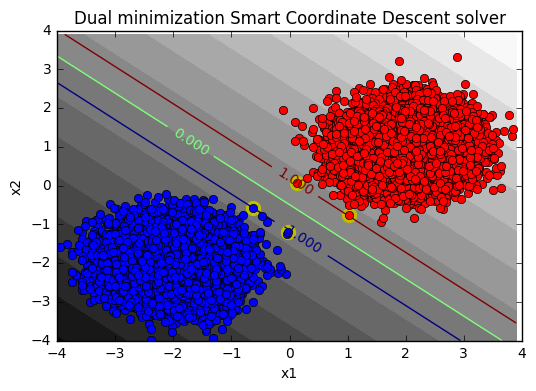

In [70]:
w, b = compute_w_b(x_cd_online, y, X)
plot_classif(X[:, :-1], y, mu_support, idx_support, b)
plt.scatter(X[idx_support][:,0],X[idx_support][:,1],label="support", color = 'y', s=100)
plt.title("Dual minimization Smart Coordinate Descent solver")